In [17]:
import logging
import numpy as np
import pandas as pd
import yaafelib
import librosa
import aubio
from aubio import onset
from appconfig import setup_logging
from scipy.io import wavfile
import matplotlib.pyplot as plt
import dsp

%matplotlib inline  

In [2]:
featurespecs = \
    ['LSF: LSF blockSize={} stepSize={}',
     'SpectralDecrease: SpectralDecrease blockSize={} stepSize={}',
     'SpectralFlatness: SpectralFlatness blockSize={} stepSize={}',
     'SpectralFlux: SpectralFlux blockSize={} stepSize={}',
     'SpectralSlope: SpectralSlope blockSize={} stepSize={}',
     'SpectralRolloff: SpectralRolloff blockSize={} stepSize={}',
     'SpectralShapeStatistics: SpectralShapeStatistics blockSize={} stepSize={}',
     'MFCC: MFCC blockSize={} stepSize={}',
     'SpectralVariation: SpectralVariation blockSize={} stepSize={}']
    
female_path = '/home/tracek/Data/gender/test/a0374.wav'
female_path2 = '/home/tracek/Data/gender/test/a0172.wav'
male_path = '/home/tracek/Data/gender/test/b0315.wav'
male_path2 = '/home/tracek/Data/gender/test/a0457.wav'

find_salient = True
sr = 16000
block_size = 1024
nfft = 512

In [3]:
def get_onsets(signal, sr, nfft, hop, onset_detector_type='hfc', onset_threshold=0.3):
    onsets = []

    onset_detector = aubio.onset(onset_detector_type, nfft, hop, sr)
    onset_detector.set_threshold(onset_threshold)

    signal_windowed = np.array_split(signal, np.arange(hop, len(signal), hop))

    for frame in signal_windowed[:-1]:
        if onset_detector(frame):
            onsets.append(onset_detector.get_last())
    return np.array(onsets[1:])

def get_start_end_samples(y, sr, nfft, hop,  onset_detector_type='hfc', onset_threshold=0.1):
    onsets_fw = get_onsets(y, sr, nfft, hop, onset_detector_type, onset_threshold)
    onsets_bw = get_onsets(y[::-1], sr, nfft, hop, onset_detector_type, onset_threshold)
    onsets_bw_rev = (len(y) - np.array(onsets_bw)[::-1])
    return onsets_fw[0], onsets_bw_rev[-1]


def get_salient_region(y, sr, start, end, start_buffer=0.0, end_buffer=0.0):
    salient_start = max(0, start - int(start_buffer * sr))
    salient_end = min(len(y), end + int(end_buffer * sr))
    return y[salient_start:salient_end]

In [4]:
def plot_feature(feature, y_len):
    x_spacing = np.linspace(0, y_len, len(feature))

    no_figures = feature.shape[1]
    if no_figures == 1:
        plt.figure(figsize=(15,5))
        plt.plot(x_spacing, feature)
    else:
        f, ax = plt.subplots(no_figures, 1, sharex=True, figsize=(15,15))
        for idx in range(no_figures):
            ax[idx].plot(x_spacing, feature[:, idx])
    plt.xlabel('time')

In [5]:
feature_plan = yaafelib.FeaturePlan(sample_rate=sr, normalize=True)
for featurespec in featurespecs:
    feature = featurespec.format(block_size, block_size // 2)
    assert feature_plan.addFeature(feature), 'Failed to load %s feature' % feature
    logging.info('Feature %s loaded', feature)
    
engine = yaafelib.Engine()
engine.load(feature_plan.getDataFlow())
afp = yaafelib.AudioFileProcessor()

In [6]:
y, sr = librosa.load(male_path2, sr=sr)
y = librosa.util.normalize(y)
if find_salient:
    y_start, y_end = get_start_end_samples(y.astype('float32'), sr, nfft=nfft, hop=nfft // 2)
    y = get_salient_region(y, sr, start=y_start, end=y_end, start_buffer=0.2, end_buffer=0.4)

In [7]:
feats = engine.processAudio(y.reshape(1, -1))
x_shape_expected = next(iter(feats.values())).shape[0] # random item
for name, feat in feats.items():
    if feat.shape[0] != x_shape_expected:
        print('Feature {} is messed up. Expected {} got {}'.format(name, x_shape_expected, feat.shape[0]))

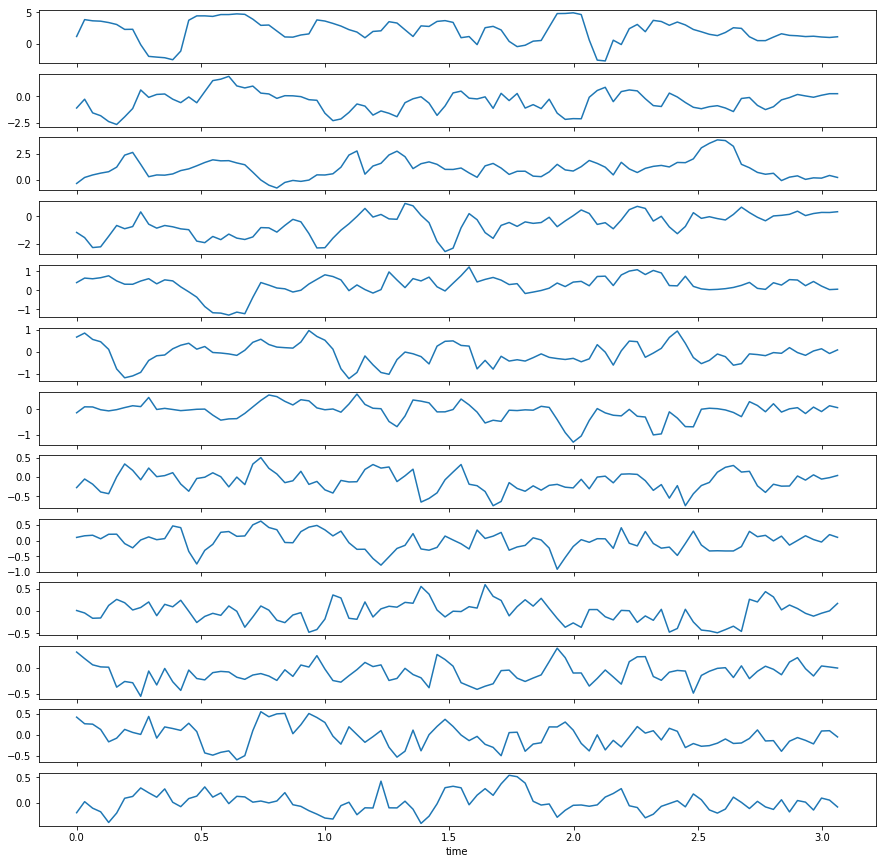

In [8]:
plot_feature(feats['MFCC'], len(y) / sr)

In [80]:
y, sr = librosa.load(male_path2, sr=sr)
y = librosa.util.normalize(y)
y = dsp.lowpass_filter(y, sr, 300, 6)

block_size = 1024
hop = block_size // 4
pitch_o = aubio.pitch("yin", block_size, hop, sr)
pitch_o.set_unit('Hz')
pitch_o.set_tolerance(0.8)
y_in = y.astype('float32')
y_win = np.array_split(y_in, np.arange(hop, len(y_in), hop))

In [81]:
pitches = []
confidences = []


for frame in y_win[:-1]:
    pitch = pitch_o(frame)[0]
    confidence = pitch_o.get_confidence()
    if confidence > tolerance:
        pitches.append(pitch)
    confidences.append(confidence)
    
pitches = np.array(pitches)

In [82]:
confidences

[0.0,
 0.0,
 0.2185148000717163,
 0.0,
 0.6538238525390625,
 0.7669150233268738,
 0.9684529900550842,
 0.9873982667922974,
 0.9943450689315796,
 0.9921126365661621,
 0.9891639947891235,
 0.9930281639099121,
 0.9915899038314819,
 0.9946399927139282,
 0.994396448135376,
 0.9942438006401062,
 0.9779561758041382,
 0.8823202848434448,
 0.5727272629737854,
 0.0,
 0.10567378997802734,
 0.02238774299621582,
 0.0,
 0.0,
 0.0,
 0.24061763286590576,
 0.0,
 0.0,
 0.0,
 0.0,
 0.4957488179206848,
 0.7135742902755737,
 0.9626759886741638,
 0.9287694692611694,
 0.9789082407951355,
 0.990317702293396,
 0.983927309513092,
 0.9831359386444092,
 0.9898351430892944,
 0.9910594820976257,
 0.9728453755378723,
 0.9671464562416077,
 0.9652491211891174,
 0.9012026190757751,
 0.9229949116706848,
 0.9689468145370483,
 0.9531528353691101,
 0.9625763297080994,
 0.917171835899353,
 0.5838009715080261,
 0.23170840740203857,
 0.5378807783126831,
 0.4510928988456726,
 0.40445929765701294,
 0.5442125797271729,
 0.394288

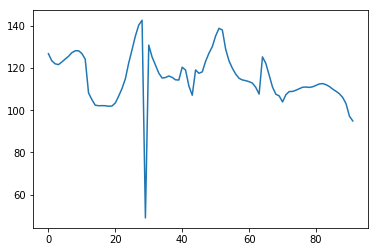

In [83]:
plt.plot(pitches)

In [84]:
pitches = pitches[pitches > pitches.mean()]

In [85]:
pitches.mean()

125.09662

In [93]:
result = {}

In [106]:
for name, feat in feats.items():
    print(name)
    print(feat.shape)
    if feat.shape[1] == 1:
        result[name] = feat.mean()
    else:
        for i in range(feat.shape[1]):
            result[name + str(i)] = feat[:,i].mean()

SpectralDecrease
(96, 1)
LSF
(96, 10)
SpectralRolloff
(96, 1)
SpectralFlatness
(96, 1)
MFCC
(96, 13)
SpectralFlux
(96, 1)
SpectralVariation
(96, 1)
SpectralSlope
(96, 1)
SpectralShapeStatistics
(96, 4)


In [107]:
feats['MFCC'].shape

(96, 13)

In [109]:
list(result.keys())

['MFCC10',
 'MFCC11',
 'LSF3',
 'SpectralFlatness',
 'MFCC7',
 'SpectralShapeStatistics0',
 'SpectralShapeStatistics3',
 'MFCC8',
 'LSF6',
 'LSF7',
 'SpectralDecrease',
 'SpectralRolloff',
 'LSF9',
 'MFCC9',
 'LSF0',
 'LSF1',
 'LSF4',
 'MFCC5',
 'LSF2',
 'LSF5',
 'MFCC4',
 'SpectralSlope',
 'MFCC2',
 'SpectralVariation',
 'SpectralShapeStatistics2',
 'SpectralShapeStatistics1',
 'MFCC6',
 'SpectralFlux',
 'MFCC3',
 'LSF8',
 'MFCC12',
 'MFCC0',
 'MFCC1']